# Graph Coloring Tutorial



This tutorial is to show how to use DomiKnows constrints solver to solve an example of the graph coloring problem.

First dowload DomiKnows and prepare the environment to execute the example.

In [ ]:
!git clone https://github.com/HLR/DomiKnowS.git
%cd DomiKnowS 
!git checkout origin/Tasks
!pip install DomiKnowS

import logging
logging.basicConfig(level=logging.INFO)

import __main__
__main__.__file__="graphcoloring.py"

## Task

The example task is to find minimal allocation of fire stations to partially interconnected cities obeying certain constraints.

## The Graph

We define the DomiKnows graph that captures the knowledge for this problem.
The graph defines concepts for *world*, *city* and type *firestationCity* of the *city* concept. If city is of this type then it has a fire station.

Additionaly, it defines the relation *neighbor*, which will be used to specyfies connections between cities. To introduce the domain and range constraints for relationships, we use the **has_a** graph structure.


In [2]:
from domiknows.graph import Graph, Concept, Relation

Graph.clear()
Concept.clear()
Relation.clear()

with Graph('global') as graph:
    world = Concept(name='world')
    city = Concept(name='city')
    (world_contains_city,) = world.contains(city)
     
    neighbor = Concept(name='neighbor')
    (city1, city2) = neighbor.has_a(arg1=city, arg2=city)
    
    firestationCity = city(name='firestationCity')

Log file for dataNode is in: /content/DomiKnowS/logs/datanode.log


<ipython-input-2-7ee974d8a431>:15: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('arg1', 'city'), ('arg2', 'city')]) is used.
  (city1, city2) = neighbor.has_a(arg1=city, arg2=city)


### Visualize
We can use the graph method *visualize* to display the graph.

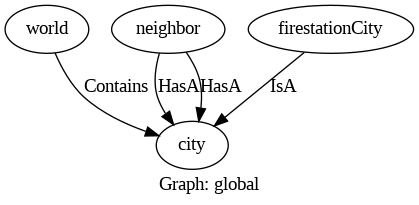

In [3]:
from IPython.display import Image
graph.visualize("./image")
Image(filename='image.png') 

## The Constrain

The constrain chosen for this example states that **for each city either a city has a fire station or exists a neighbor city which has a fire station**.

To define it, we use nested constraint *existL* inside the *orL* constraint.

In [4]:
from domiknows.graph.logicalConstrain import orL, existsL

with graph:
  orL(firestationCity('x'), existsL(firestationCity('y', path=('x', neighbor.name, city2.name))))

## Data and Data Reader

Here we use a simple reader to define cities of our example and their connections. The reader defines the number of cities and their connections. **You can modify the data to solve different world of cities or neighbors connections.**

In [5]:
class CityReader:
    def __init__(self,):
        self.data = [[1, 2, 3, 4, 5, 6, 7, 8, 9]]
        self.links = [{
            1: [1, 2, 3, 4, 5],
            2: [1, 2, 6],
            3: [1, 3],
            4: [1, 4],
            5: [1, 5],
            6: [6, 7, 8, 9, 2],
            7: [6, 7],
            8: [6, 8],
            9: [6, 9]
        }]

    def run(self,):
        for i in range(len(self.data)):
            item = {'world':[0], 'city': self.data[i], 'links': self.links[i]}
            yield item

## Model Declaration

In this section, we start by defining example sensors and required toolkits and then start connecting the sensors and learners to their right place in the DomiKnows graph.


In this example we not using learning but only constraints solution. Thus, we will define a dummy learner initialize all output for cities to 1 and handling the problem of finding the allocation of firestation to cities to the constraint’s solver.

In [7]:
from domiknows.sensor.pytorch.learners import TorchLearner
import torch

class DummyCityLearner(TorchLearner):
    def forward(self, x):
        result = torch.zeros(len(x), 2)

        # Initially all cities are firestation cities
        result[:, 1] = 1
        
        return result

Next we import a set of our predefined basic sensors which enables us to use the functionality of the DomiKnows declarative sensor and learner definition.

In [8]:
from domiknows.sensor.pytorch.sensors import ReaderSensor
from domiknows.sensor.pytorch.relation_sensors import EdgeSensor, CompositionCandidateReaderSensor

graph.detach()

Then we start by defining  **ReaderSensor**s to connect our *CityReader* DataLoader with properties in the graph by using approperiate *keyword*s.

In [9]:
world['index'] = ReaderSensor(keyword='world')
city['index'] = ReaderSensor(keyword='city')
city[world_contains_city] = EdgeSensor(city['index'], world['index'], relation=world_contains_city, forward=lambda x, _: torch.ones_like(x).unsqueeze(-1))

Next, we define the pair concept and use the **CompositionCandidateReaderSensor** to generate pair candidates based on *links* in provided data. This sensor receives two cities at a time and return **True** to make a candidate pair for that combination of cities or **False** to skip the combination.

In [10]:
def readNeighbors(index, data, arg1, arg2):
        city1, city2 = arg1, arg2
        if city1.getAttribute('index') in data[int(city2.getAttribute('index'))]:
            return True
        else:
            return False

neighbor[city1.reversed, city2.reversed] = CompositionCandidateReaderSensor(city['index'], keyword='links', relations=(city1.reversed, city2.reversed), forward=readNeighbors)

Finnaly, we initialized a *DummyCityLearner* learner on top of the *firestationCity* concept.

In [11]:
city[firestationCity] = DummyCityLearner('index')

After connecting all the sensors and learner to the graph, we have to define a Program instance to be able to autoamtically train and test our models. Here, we use the **LearningBasedProgram**. 

In [12]:
from domiknows.program import LearningBasedProgram
from domiknows.program.model.pytorch import model_helper, PoiModel

program = LearningBasedProgram(graph, model_helper(PoiModel, poi=[world, city, city[firestationCity], neighbor]))

 To start we run the *CityReader* to load the example data and then *populate* the sensors. The result ofthis action is a *datanode* structure which in the graph form stores all the example data and sensors outputs.

In [13]:
dataset = CityReader().run()  # Adding the info on the reader

datanode = next(program.populate(dataset=dataset), None)

0it [00:00, ?it/s]


Let's display the initial assignment of fire stations to cities.

In [14]:
for child_node in datanode.getChildDataNodes():
    if child_node.getAttribute('<' + firestationCity.name + '>')[1].item() == 1:
      print("City %s has fire station "%(child_node.getAttribute("index").item()))

City 1 has fire station 
City 2 has fire station 
City 3 has fire station 
City 4 has fire station 
City 5 has fire station 
City 6 has fire station 
City 7 has fire station 
City 8 has fire station 
City 9 has fire station 


 ## DomiKnows constraints solver 



The solver is invoked by calling the *inferILPResults* method on *datanode*. The method takes collection of concepts for which the constraints should be solved.
In the case on this example, we also use the solver to minimize the objective - we want to find the minimal set of fire station fulfilling the constrain requirements.


In [15]:
conceptsRelations = (firestationCity)  
datanode.inferILPResults(*conceptsRelations, fun=None, minimizeObjective=True) 

Log file for ilpOntSolver is in: /content/DomiKnowS/logs/ilpOntSolver.log
Log file for ilpOntSolverTime is in: /content/DomiKnowS/logs/ilpOntSolver.log


The fire stations minimal allocation to cities, obeying the constrain, is:

In [16]:
for child_node in datanode.getChildDataNodes():
    if child_node.getAttribute(firestationCity, 'ILP').item() == 1:
      print("City %s has fire station "%(child_node.getAttribute("index").item()))

City 1 has fire station 
City 6 has fire station 


##Additional constraint

We can modify or introduce additional constraint to our example and this will change the calculated results. For instance, additional constraints can require that **each city has no more than 4 neighbors which are not firestationCity**.

In [17]:
from domiknows.graph.logicalConstrain import ifL, atMostL, notL, eqL

with graph:
    ifL(city('x'), atMostL(notL(firestationCity( path=('x', neighbor.name, city2.name) )), 3))

Invoke the solver to recalculate the solution.

In [18]:
datanode.inferILPResults(*conceptsRelations, fun=None, minimizeObjective=True) 

The fire stations minimal allocation to cities, obeying the updated constrain, is:

In [19]:
for child_node in datanode.getChildDataNodes():
    if child_node.getAttribute(firestationCity, 'ILP').item() == 1:
      print("City %s has fire station "%(child_node.getAttribute("index").item()))

City 1 has fire station 
City 2 has fire station 
City 6 has fire station 
